# PHY432: Final Project:
# Gravitational Impacts of the Death Star on Endor and Earth-like Planets
### The Skywalkers

## Experiments and other work

v 0.9911817939608795
3.003268795574554e-06
-4.466526641772694e-12
[0.01749395 0.01750284 0.01764507]



100%|██████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1848.11it/s]


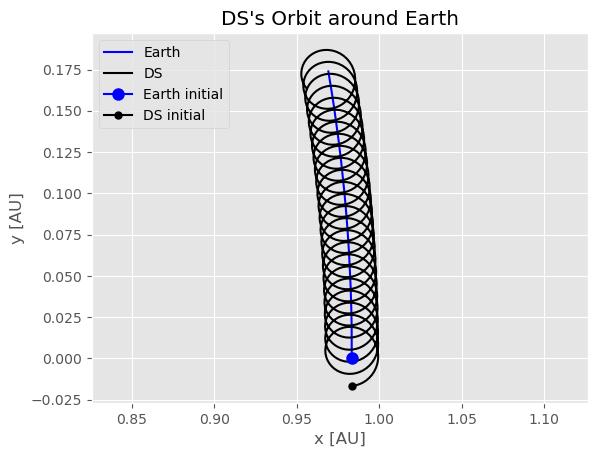

In [16]:
# PHY432: Final Project
# Team: The Skywalkers
# Members: Simon Tebeck, Pranav Gupta
# April 2024


# import packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")
import tqdm

# integrators
# import integrators



# =============================================================================
# 1. Initialising parameters
# =============================================================================


# gravitational constant
G_gravity = 4*np.pi**2 *(1/365.256)**2 # astronomical units but per days not years
yr = 365.256 # days

# astronomical unit
au =  1.495978e8 # km (!!)

def AU(x): return x/au
def AU_inv(x): return x*au


# masses
# SI
mass_sun = 1.9885E+30 # kg
mass_earth = 5.972E+24 # kg
mass_moon = 7.35E+22 # kg
mass_endor = 7.52E+23 # kg
# mass_bb =


# Astronomical units
# DS_A: Death Star (light estimation)
# DS_B: Death Star (heavy estimation)
mass = {'Sun': 1.,
        'Earth': mass_earth/mass_sun,
        'Moon': mass_moon/mass_sun,
        'Endor': mass_endor/mass_sun,
        'DS_A': 1e18/mass_sun,
        'DS_B': 2.8e23/mass_sun
        }

# orbital period in Earth days
period = {'Earth': 365.256,
          'Moon': 1
          }

# for earth: use pre-determined speed at perihelion: 30.29 km/s
speed_earth = 30.29 * 3600*24 / au # speed earth around sun at perihelion
# for moon: speed at apogee: 0.966 km/s
speed_moon =  0.966 * 3600*24 / au # speed moon around earth at apogee
# for DS: number that lead to stable orbits
speed_DS = 3.99 * 3600*24 / au # speed DS around earth


# distance from the respective orbit center in AU
# note: Earth distance at perihelion (closest), Moon at apogee (farthest)
distance = {'Earth': 1.47098074e8 / au, # e8 is in km!!
            'Moon': 4.05696e5 / au,
            'DS': 2.5e4 / au,
            }

# radii of the objects
radius = {'Sun':696000 / au,
          'Earth': 6357 / au,
          'Moon': 1737 / au,
          'Endor': 2450 / au,
          'BB': 74000 / au,
          'DS': 100 / au
          }

print('v', np.sqrt(G_gravity*mass['Earth']/distance['Moon'])*au /(3600*24))
print(mass['Earth'])
# print(speed_moon)
print(-G_gravity*mass['Earth']*mass['Moon']/distance['Moon']**2)
# =============================================================================
# 2. Functions for the orbit calculations (Solar System) (for Endor System
# see other file in Submission)
# =============================================================================


def initial_position(distance, angle=0):
    """Calculate initial planet position.

    Parameters
    ----------
    angle : float
       initial angle relative to x axis (in degrees)
    distance : float
       initial distane from sun (in AU)

    Returns
    -------
    array
       position (x, y)
    """
    x = np.deg2rad(angle)
    return distance * np.array([np.cos(x), np.sin(x)])




def F_gravity(r, m, M):
    """Force due to gravity between two masses.

    Parameters
    ----------
    r : array
      distance vector (x, y)
    m, M : float
      masses of the two bodies

    Returns
    -------
    array
       force due to gravity (along r)
    """
    rr = np.sum(r * r)
    rhat = r / np.sqrt(rr)
    force_magnitude = - G_gravity * m * M / rr* rhat
    return force_magnitude


def omega(v, r):
    """Calculate angular velocity.

    The angular velocity is calculated as
    .. math::

          \omega = \frac{|\vec{v}|}{|\vec{r}|}

    Parameters
    ----------
    v : array
       velocity vectors for all N time steps; this
       should be a (N, dim) array
    r : array
       position vectors (N, dim) array

    Returns
    -------
    array
       angular velocity for each time step as 1D array of
       length N
    """
    speed = np.linalg.norm(v, axis=1)
    distance = np.linalg.norm(r, axis=1)
    return speed/distance


def dist(r1, r2):
    '''
    Parameters r1, r2: np.array of shape r = [x,y]
    Returns absolute value of the distance of connection vector
    '''
    return np.sqrt(np.sum((r1-r2)**2))


def crash_detect(r):
    crash = False
    [r1, r2, r3] = r
    if dist(r1, [0,0]) < (radius['Sun']+radius['Earth']):
        print('\nEarth crashed into the Sun!')
        crash = True
    elif dist(r1, r2) < (radius['Moon']+radius['Earth']):
        print('\nMoon crashed into the Earth!')
        crash = True
    elif dist(r1, r3) < (radius['DS']+radius['Earth']):
        print('\nDeathstar crashed into the Earth!')
        crash = True
    elif dist(r3, np.array([0,0])) < (radius['DS']+radius['Sun']):
        print('\nDeathstar crashed into the Sun!')
        crash = True
        
    return crash


# calculate the total force
# r: input array [[x_Earth,y_Earth],[x_Moon,y_Moon],[x_DS,y_DS]]
def F_total(r, m_earth=mass['Earth'], m_DS=mass['DS_A'],
            sun=True, moon=False, DS=False, earth_fixed=False):
    
    # masses
    m_sun = mass['Sun']
    m_moon = mass['Moon']
    
    # radii of objects
    r_earth = r[0]
    r_moon = r[1]
    r_DS = r[2]
    
    # deactivate sun if only orbits around Earth shall be observed
    sunfactor = (1 if sun else 0) # ;)
    
    # deactivate forces acting on earth if earth should be held fixed
    earthfactor = (0 if earth_fixed else 1)
    
    # note: F_x_y means force points from y to x
    if moon:
        # simulate moon
        F_sun_moon = F_gravity(r_moon, m_moon, m_sun) * sunfactor
        F_earth_moon = F_gravity(r_moon-r_earth, m_moon, m_earth)
        
        if DS:
            # simulate DS
            F_sun_DS = F_gravity(r_DS, m_DS, m_sun) * sunfactor
            F_earth_DS = F_gravity(r_DS-r_earth, m_DS, m_earth)
            F_moon_DS = F_gravity(r_DS-r_moon, m_DS, m_moon)
        else:
            # no interactions with DS
            F_sun_DS = F_earth_DS = F_moon_DS = np.zeros(2)
    
    else:
        #no interactiosn with moon
        F_sun_moon = F_earth_moon = F_moon_DS = np.zeros(2)
        
        if DS:
            # simulate DS
            F_sun_DS = F_gravity(r_DS, m_DS, m_sun) * sunfactor
            F_earth_DS = F_gravity(r_DS-r_earth, m_DS, m_earth)
        else:
            # no interactions with DS
            F_sun_DS = F_earth_DS = np.zeros(2)
            
    # always: Earth-Sun
    F_sun_earth = F_gravity(r_earth, m_earth, m_sun) * sunfactor
    
    # total force
    F_tot = np.array([F_sun_earth - F_earth_moon - F_earth_DS,
                      F_sun_moon + F_earth_moon - F_moon_DS,
                      F_sun_DS + F_earth_DS + F_moon_DS])
    # account for fixed earht (=setting all forces acting on earth to zero)
    F_tot[0] *= earthfactor
    
    return F_tot
    


# main algorithm: integrate the orbits
def integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_A'], 
                     distance_DS=distance['DS'], _speed_DS=speed_DS,
                     dt=0.1, t_max=160, sun=True, moon=False, DS=False,
                     earth_fixed=False):
    """Integrate equations of motion
    """
    nsteps = int(t_max/dt)
    time = dt * np.arange(nsteps)
    
    # masses
    m_moon = mass['Moon']
    
    # speeds from global variables
    _speed_earth = speed_earth * (1 if sun else 0) # when sun neglected, see earth as center
    _speed_moon = speed_moon
    
    rt = np.zeros((nsteps, 3, 2)) # [[x_ea,y_ea],[x_mo,y_mo],[x_DS,y_DS]] for every time step
    vt = np.zeros_like(rt)
    
    # initialising earth
    rt[0,0,:] = initial_position(distance['Earth'])
    vt[0,0,:] = np.array([0, _speed_earth])
    
    # initialising moon
    rt[0,1,:] = initial_position(distance['Earth']) + np.array([0,distance['Moon']])
    vt[0,1,:] = np.array([- _speed_moon, _speed_earth])
    
    # initialising Death Star
    rt[0,2,:] = initial_position(distance['Earth']) + np.array([0,-distance_DS])
    vt[0,2,:] = np.array([1*_speed_DS, _speed_earth])
    
    print(np.sqrt(np.sum((vt[0])**2, axis=1)))
    print()

    # integration verlocity verlet
    Ft = F_total(rt[0], m_earth=m_earth, m_DS=m_DS, sun=sun, moon=moon, DS=DS,
                 earth_fixed=earth_fixed)
    
    for i in tqdm.tqdm(range(nsteps-1)):
        # print(vt[i,0])
        # print(dist(rt[i,2], np.array([0,0])), Ft[2])
        m = np.array([[m_earth, m_earth],
                     [m_moon, m_moon],
                     [m_DS, m_DS]])
        vhalf = vt[i] + 0.5 * dt * Ft / m
        rt[i+1] = rt[i] + dt * vhalf
    
        # new force
        Ft = F_total(rt[i+1], m_earth=m_earth, m_DS=m_DS, moon=moon, DS=DS,
                     sun=sun, earth_fixed=earth_fixed)
        # print(Ft[1])
        vt[i+1] = vhalf + 0.5 * dt * Ft / m
        # print(np.sqrt(np.sum((vt[i+1])**2, axis=1)))
        
        # crash detection: important to stop, otherwise F explodes
        if crash_detect(rt[i+1]):
            print('STOP SIMULATION')
            print('CELESTIAL CATASTROPHE, PEOPLE DIED!')
            # set all remaining r to the current r[i]
            rt = np.where(rt==np.zeros((3,2)), rt[i+1], rt)
            break

    return time, rt, vt

dt=1e-2
t_max=10
sun=True
earth_fixed=False
# time1, r1, v1 = integrate_orbits(m_earth=mass['Earth'],
#                               dt=dt, t_max=t_max)
time2, r2, v2 = integrate_orbits(m_earth=mass['Earth'], m_DS=mass['DS_B'],
                                 sun=sun, moon=False, DS=True, dt=dt, t_max=t_max,
                                 earth_fixed=earth_fixed)
# time3, r3, v3 = integrate_orbits(m_earth=mass['Earth']+mass['DS_B'],
#                               dt=dt, t_max=t_max)
# time4, r4, v4 = integrate_orbits(m_earth=mass['Earth']+mass['DS_B']+mass['Moon'],
#                               dt=dt, t_max=t_max)

# plt.plot(r1[:,0,0], r1[:,0,1], label='Earth')
# plt.plot(0,0, marker='o', markersize=20, color='yellow')
# plt.show()
def stretch_distance(rt, index=1, alpha=30):
    r1 = rt[:,0]
    r2 = rt[:,index]
    rt[:,index] = r1 + alpha * (r2 - r1)
    return rt
    
r2 = stretch_distance(r2, 1)
r2 = stretch_distance(r2, 2, 100)

plt.plot(r2[:,0,0], r2[:,0,1], c='b', label='Earth')
# plt.plot(r2[:,1,0], r2[:,1,1], c='grey', label='Moon')
plt.plot(r2[:,2,0], r2[:,2,1], c='black', label='DS')
plt.plot(r2[0,0,0], r2[0,0,1], marker='o', c='b', markersize=8, label='Earth initial')
# plt.plot(r2[0,1,0], r2[0,1,1], marker='o', c='grey', markersize=5, label='Moon initial')
plt.plot(r2[0,2,0], r2[0,2,1], marker='o', c='black', markersize=5, label='DS initial')
# plt.ylim(-2, 2)
# plt.plot(r3[:,0,0], r3[:,0,1], label='Earth + DS_B')
# plt.plot(r4[:,0,0], r4[:,0,1], label='Earth + Moon + DS_B')
# if sun:
#     plt.plot(0,0, marker='o', markersize=20, color='yellow')
plt.title('DS\'s Orbit around Earth')

plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend(loc=2)
plt.axis('equal')
# plt.savefig('Earth_DS_B.png', dpi=300, bbox_inches='tight')
plt.show()


In [4]:
x = np.array([[[1,1],[2,2],[3,3]],
             [[0,0],[0,0],[0,0]]])
x = np.where(x==np.zeros((3,2)), [[1,1],[2,2],[3,3]], x)

In [12]:
# %matplotlib widget

In [21]:
# import matplotlib.animation as animation

In [ ]:
# y_limits = x_limits = -1.5, 1.5

# fig1 = plt.figure(figsize=(5,5))
# ax = fig1.add_subplot(111)
# ax.set_aspect(1)

# def update_wave(frame, data):
#     global ax, dt, y_limits, x_limits
#     ax.clear()
#     ax.set_xlabel("x [AU]")
#     ax.set_ylabel("y [AU]")
#     ax.plot(data[frame,0,0], data[frame,0,1], marker='o', markersize=20, label='Earth')
#     #plt.plot(data[frame,1,0], data[frame,1,1], label='Moon')
#     ax.plot(0,0, marker='o', markersize=20, color='yellow')
#     ax.legend()
#     ax.set_ylim(y_limits)
#     ax.set_xlim(x_limits)
#     # ax.text(0.1, 0.9, "t = {0:3.1f} ms".format(frame*Dt*1e3), transform=ax.transAxes)

# wave_anim = animation.FuncAnimation(fig1, update_wave, frames=len(r2), fargs=(r2,), 
#                                     interval=0, blit=False, repeat_delay=100)

In [23]:
# wave_anim.pause()

Moviepy - Building video death_star_around_earth.mp4.
Moviepy - Writing video death_star_around_earth.mp4



Moviepy - Done !
Moviepy - video ready death_star_around_earth.mp4


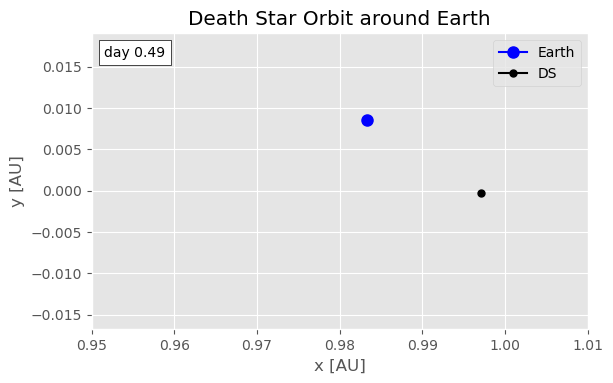

In [38]:
import moviepy.editor as mpy
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from matplotlib.offsetbox import AnchoredText

duration = 2
fps = 25
max_frame = int(duration*fps)
a = 1


y_limits = (r2[:max_frame,2,1].min() *a, r2[:max_frame,2,1].max() *a) 
x_limits = (r2[:max_frame,2,0].min() *a, r2[:max_frame,2,0].max() *a)

y_limits = r2[:max_frame,2,1].min(), r2[:max_frame,2,1].max()
x_limits = 0.95, 1.01

fig, ax = plt.subplots()

def make_frame(t):
    global r2, dt, x_limits, y_limits, fps
    frame = int(t*fps)
    
    ax.clear()
    ax.set_title('Death Star Orbit around Earth')
    ax.set_xlabel("x [AU]")
    ax.set_ylabel("y [AU]")
    ax.add_artist(AnchoredText(f'day {frame*dt:.2f}', loc=2))
    ax.plot(r2[frame,0,0], r2[frame,0,1], marker='o', c='b', markersize=8, label='Earth')
    ax.plot(r2[frame,2,0], r2[frame,2,1], marker='o', c='black', markersize=5, label='DS')
    ax.legend()
    ax.set_aspect('equal', 'box')
    ax.set(xlim=(x_limits), ylim=(y_limits))
    # ax.plot(0,0, marker='o', markersize=20, color='yellow')
    # ax.set_ylim(y_limits)
    # ax.set_xlim(x_limits)
    return mplfig_to_npimage(fig)

filename = 'death_star_around_earth.mp4'
animation = VideoClip(make_frame, duration=duration)
animation.write_videofile(filename, fps=fps)
mpy.ipython_display(filename, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


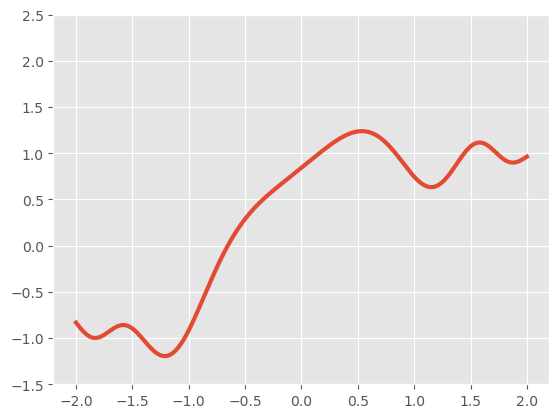

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

x = np.linspace(-2, 2, 200)

duration = 2

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.plot(x, np.sinc(x**2) + np.sin(x + 2*np.pi/duration * t), lw=3)
    ax.set_ylim(-1.5, 2.5)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=20, loop=True, autoplay=True)

In [9]:
sun = True
5 * (1 if sun else 0)

0

In [8]:
# estimating the tidal effects of the Death Star based on gravitational differences
G = 6.67384e-11

mass_sun = 1.9885E+30 # kg
mass_earth = 5.972E+24 # kg
mass_moon = 7.35E+22 # kg
mass_endor = 7.52E+23 # kg
mass_DS_A = 1e18 # kg
mass_DS_B = 2.8e23 # kg

# distance from the respective orbit center in AU
# note: Earth distance at perihelion (closest), Moon at apogee (farthest)
distance = {'Earth': 1.47098074e11, # in m!!
            'Moon': 4.05696e8,
            'DS': 2.5e7,
            }

# radii of the objects
radius = {'Sun':696000e3, # m!
          'Earth': 6357e3,
          'Moon': 1737e3,
          'Endor': 2450e3,
          'BB': 74000e3,
          'DS': 100e3
          }

d_moon = distance['Moon']
d_sun = distance['Earth']
d_DS = d_DS_A = d_DS_B = distance['DS']
r_earth = radius['Earth']

delta_g_moon = G*mass_moon * (1/(d_moon-r_earth)**2 - 1/(d_moon+r_earth)**2)
delta_g_sun = G*mass_sun * (1/(d_sun-r_earth)**2 - 1/(d_sun+r_earth)**2)
delta_g_DS_A = G*mass_DS_A * (1/(d_DS-r_earth)**2 - 1/(d_DS+r_earth)**2)
delta_g_DS_B = G*mass_DS_B * (1/(d_DS-r_earth)**2 - 1/(d_DS+r_earth)**2)

print(f'Tidal effect of the moon: {delta_g_moon:.3e}')
print(f'Tidal effect of the sun:  {delta_g_sun:.3e}')
print(f'Tidal effect of the DS_A: {delta_g_DS_A:.3e}')
print(f'Tidal effect of the DS_B: {delta_g_DS_B:.3e}')

Tidal effect of the moon: 1.869e-06
Tidal effect of the sun:  1.060e-06
Tidal effect of the DS_A: 1.241e-07
Tidal effect of the DS_B: 3.476e-02


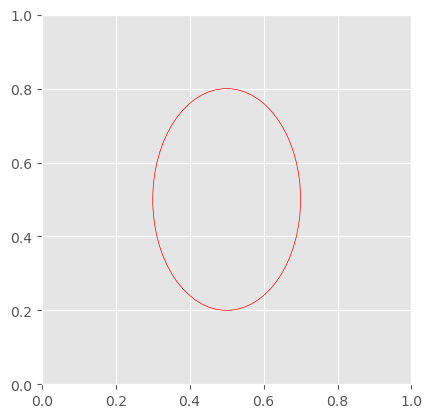

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots()

# Create an ellipse patch
ellipse = patches.Ellipse((0.5, 0.5), width=0.4, height=0.6, angle=0, edgecolor='r', facecolor='none')

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set aspect ratio to equal to make sure the ellipse is not distorted
ax.set_aspect('equal')

# Set axis limits
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Show the plot
plt.show()